# Segunda práctica de Aprendizaje Automático

Implementación del grupo 17, formado por:
- Sergio Barragán Blanco (100472343)
- Eduardo Alarcón Navarro (100472175)

# Lectura del fichero CSV


In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Carga de datos
def load_data():
    data = pd.read_csv('Stars2.csv')
    return data
data = load_data()


# A continuación, haremos nuestra propia implementación del Kmeans
Con el objetivo de, posteriormente, comparar nuestra implementación con la oficial de scikit-learn

In [79]:

class Kmeans():
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = 343175
        self.cluster_centers_ = None
        self.labels_ = None

    def fit(self, X, y=None, sample_weight=None):
        # Inicialización de los centroides de manera aleatoria
        rng = np.random.default_rng(self.random_state)
        self.cluster_centers_ = rng.choice(X, size=self.n_clusters, replace=False)

        for _ in range(self.max_iter):
            self._assign_labels(X)

            new_centers = self._compute_centers(X, self.labels_)

            if np.allclose(self.cluster_centers_, new_centers, atol=self.tol):
                break
            
            self.cluster_centers_ = new_centers

    def _assign_labels(self, X):
        labels = np.empty(X.shape[0], dtype=int)
        for i, x in enumerate(X):
            # Calcular la distancia euclidiana a cada centroide
            distances = np.linalg.norm(self.cluster_centers_ - x, axis=1)
            # Asignar el punto al clúster con la distancia más corta
            labels[i] = np.argmin(distances)
        self.labels_ = labels

    def _compute_centers(self, X, labels):
        new_centers = np.empty_like(self.cluster_centers_)
        for i in range(self.n_clusters):
            # Calcular el nuevo centroide como el promedio de los puntos asignados al clúster i
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centers[i] = np.mean(cluster_points, axis=0)
            else:
                # Si no hay puntos asignados al clúster, mantener el centroide actual
                new_centers[i] = self.cluster_centers_[i]
        return new_centers


# A continuación, haremos el encoding de los datos, podemos hacer tanto OneHot como Ordinal
Dado que nuestro objetivo principal es la comparación de ambos KMeans, vamos a usar Ordinal Encoder para las dos columnas de datos de clasificación, ya que ambas se rigen por un orden.

In [80]:
# Dado que las instancias de la columa "Color", son variadas lo primero, es normalizarlas
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

# ChatGPT redució la función a esto
data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))

# Codificación ordinal de los colores
color_encoder = OrdinalEncoder(categories=[normalized_colors])
color_encoded = color_encoder.fit_transform(data[['Color']])

# Como la clase espectral si es consistente, no se le aplicará normalización y haremos directamente el encoding
spectral_encoder = OrdinalEncoder(categories=[['O', 'B', 'A', 'F', 'G', 'K', 'M']])
spectral_class_encoded = spectral_encoder.fit_transform(data[['Spectral_Class']])

data['Color'] = color_encoded
data['Spectral_Class'] = spectral_class_encoded


# Preparación de los datos y comparaciones
A continuación, vamos a aplicarle a los datos un Standard Scaler, y un PCA para reducir la dimensionalidad tratando de mantener la mayor cantidad de información posible y comparar ambos KMeans usando gráficos de burbujas.

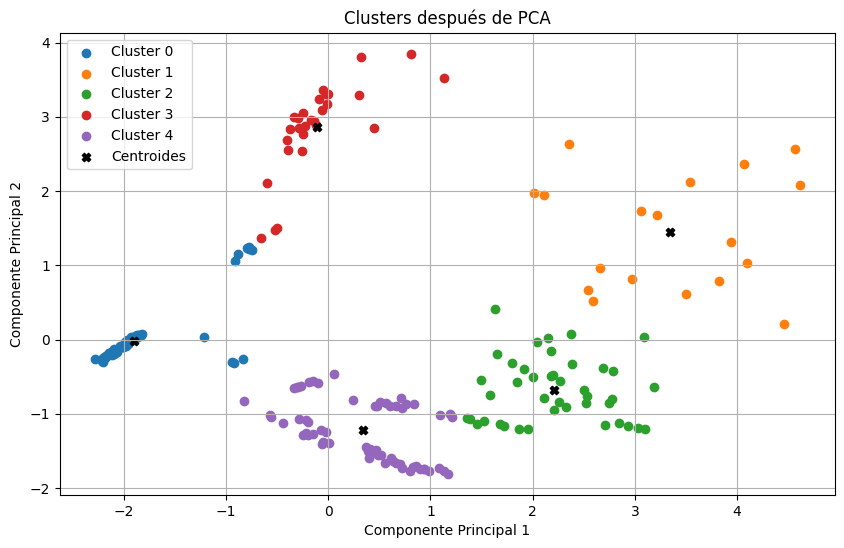

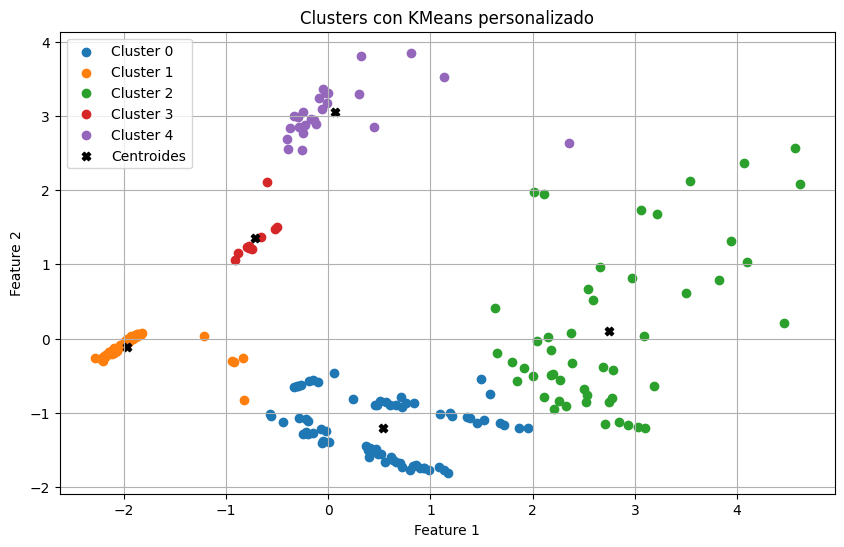

In [81]:
# Escalado de características
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
"""Aquí empieza la implemetación oficial de KMeans de scikit-learn"""
# Clustering con KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_pca)

# Predicciones de cluster
cluster_labels = kmeans.predict(data_pca)

# Y lo mostramos en una gráfica.
plt.figure(figsize=(10, 6))
for label in np.unique(cluster_labels):
    plt.scatter(data_pca[cluster_labels == label, 0], data_pca[cluster_labels == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters después de PCA')
plt.legend()
plt.grid(True)
plt.show()

"""Por último implementamos nuestro propio KMeans, el cual se inicializa de manera similar, pero se llama con la n en minúscula"""
kmeans = Kmeans(n_clusters=5)
kmeans.fit(data_pca)

# Mostrando los resultados
plt.figure(figsize=(10, 6))
for label in np.unique(kmeans.labels_):
    plt.scatter(data_pca[kmeans.labels_ == label, 0], data_pca[kmeans.labels_ == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters con KMeans personalizado')
plt.legend()
plt.grid(True)
plt.show()


# Conclusiones

# Comparación de Encoders y de métodos de clustering
Una vez hemos comaprados ambos Kmeans usando usando el mismo método con los datos (ordinal encoder), vamos a comprobar si nuestra decisión fué la correcta, probando ahora con OneHot encoding y con algortimos de clustering como hierchical o DBSCAN.

#### OneHot Encoding VS Ordinal Encoding
Para probar cual es mejor para nuestro conjunto de entrenamiento, usaremos copias de los datos originales y le iremos aplicando todas las posibles combinaciones de ambos encoders, almacenando los resultados para ser posteriormente evaluados por los métodos de clustering.

In [82]:
from itertools import product # Para sacar las combinaciones de OHE y Ordinal

# Para evitar problemas innecesarios, crearemos una copia nueva para los datos y trabajaremos sobre ella
data = pd.read_csv('Stars2.csv')
# Dado que los problemas de mapeo vuelven a surgir, será necesario volver a normalizar el color
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))
spectrum = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Lista para almacenar los resultados
master_data = []

# Iterar sobre todas las combinaciones de codificación para color y clase espectral
for color_encoding, spectral_encoding in product(['O', 'H'], repeat=2):
    df = data.copy()
    
    # Codificación ordinal de color
    if color_encoding == 'O':
        color_encoder = OrdinalEncoder(categories=[normalized_colors])
        df['Color_Encoded'] = color_encoder.fit_transform(df[['Color']])
    else:
        color_encoder = OneHotEncoder(categories=[normalized_colors])
        color_encoded = color_encoder.fit_transform(df[['Color']])
        color_encoded_df = pd.DataFrame(color_encoded.toarray(), columns=[f'Color_{i}' for i in range(1, 10)])
        df = pd.concat([df, color_encoded_df], axis=1)
    
    # Codificación ordinal de clase espectral
    if spectral_encoding == 'O':
        spectral_encoder = OrdinalEncoder(categories=[spectrum])
        df['Spectral_Class_Encoded'] = spectral_encoder.fit_transform(df[['Spectral_Class']])
    else:
        spectral_encoder = OneHotEncoder(categories=[spectrum])
        spectral_encoded = spectral_encoder.fit_transform(df[['Spectral_Class']])
        spectral_encoded_df = pd.DataFrame(spectral_encoded.toarray(), columns=[f'Spectral_Class_{i}' for i in range(1, 8)])
        df = pd.concat([df, spectral_encoded_df], axis=1)
    
    # Eliminar las columnas originales de color y clase espectral
    df.drop(['Color', 'Spectral_Class'], axis=1, inplace=True)
    
    # Agregar la tupla a master_data
    master_data.append((color_encoding, spectral_encoding, df))




#### KMeans VS Hierchical VS DBSCAN
Ahora que ya tenemos almacenadas todas las psoibles combinaciones para converitr los datos catergóricos, vamos a usar los métodos de clustering para encontrar la mejor solución para el problema.

Data Combination: Color Encoding - O, Spectral Encoding - O
Distribución de puntos por cluster
  Clustering Algorithm: KMeans


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

Para KMeans ---- Teniendo: Color O ----- Spectral ----- O
La mejor puntuación usando {} = nan
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 2, 'tol': 0.0001}
    Cluster 0: 112 puntos
    Cluster 1: 128 puntos


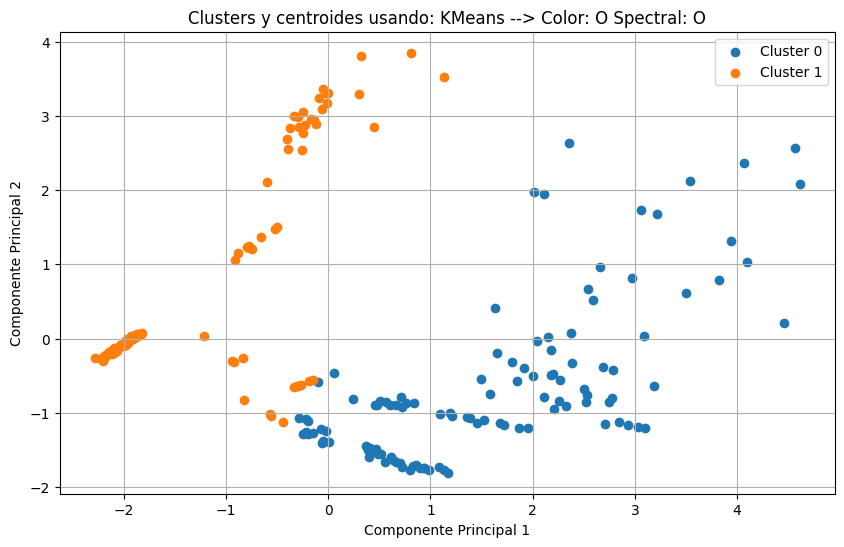

  Clustering Algorithm: Hierarchical Clustering


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

Para Hierarchical Clustering ---- Teniendo: Color O ----- Spectral ----- O
La mejor puntuación usando {} = nan
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}
    Cluster 0: 114 puntos
    Cluster 1: 126 puntos


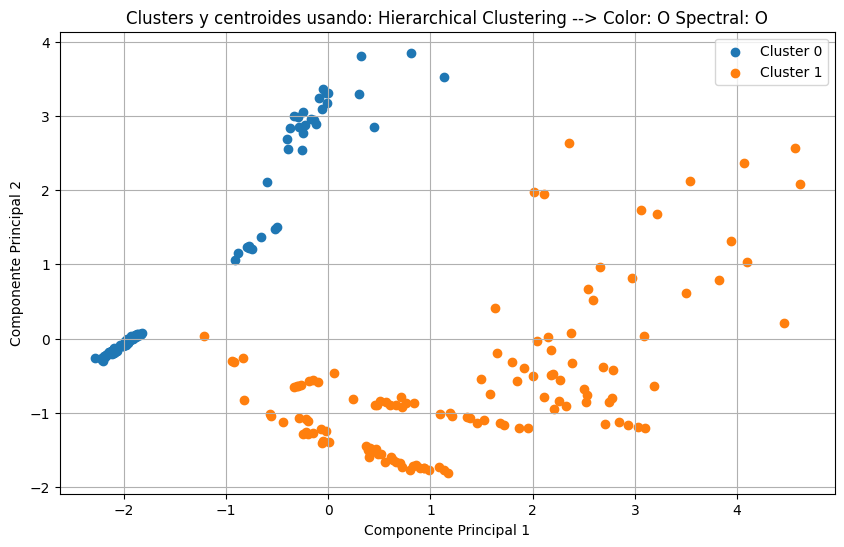

  Clustering Algorithm: DBSCAN


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

Para DBSCAN ---- Teniendo: Color O ----- Spectral ----- O
La mejor puntuación usando {} = nan
 Los mejores parámetos = {'eps': 0.1, 'metric': 'euclidean', 'min_samples': 2}
    Cluster -1: 55 puntos
    Cluster 0: 80 puntos
    Cluster 1: 3 puntos
    Cluster 2: 6 puntos
    Cluster 3: 13 puntos
    Cluster 4: 3 puntos
    Cluster 5: 3 puntos
    Cluster 6: 2 puntos
    Cluster 7: 2 puntos
    Cluster 8: 2 puntos
    Cluster 9: 10 puntos
    Cluster 10: 7 puntos
    Cluster 11: 4 puntos
    Cluster 12: 2 puntos
    Cluster 13: 2 puntos
    Cluster 14: 2 puntos
    Cluster 15: 4 puntos
    Cluster 16: 7 puntos
    Cluster 17: 2 puntos
    Cluster 18: 8 puntos
    Cluster 19: 2 puntos
    Cluster 20: 2 puntos
    Cluster 21: 2 puntos
    Cluster 22: 2 puntos
    Cluster 23: 3 puntos
    Cluster 24: 2 puntos
    Cluster 25: 2 puntos
    Cluster 26: 4 puntos
    Cluster 27: 2 puntos
    Cluster 28: 2 puntos


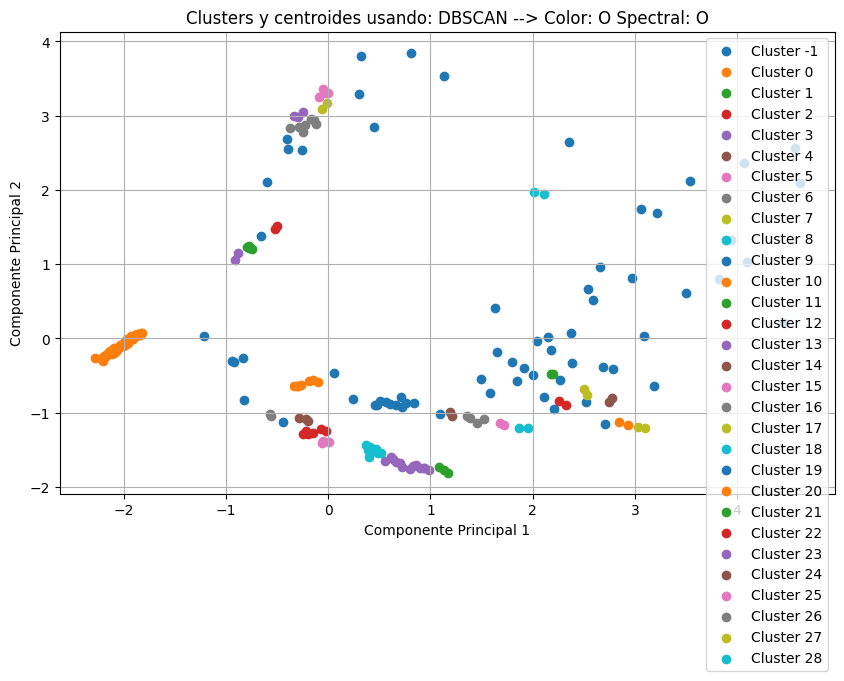



Data Combination: Color Encoding - O, Spectral Encoding - H
Distribución de puntos por cluster
  Clustering Algorithm: KMeans


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

Para KMeans ---- Teniendo: Color O ----- Spectral ----- H
La mejor puntuación usando {} = nan
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 2, 'tol': 0.0001}
    Cluster 0: 122 puntos
    Cluster 1: 118 puntos


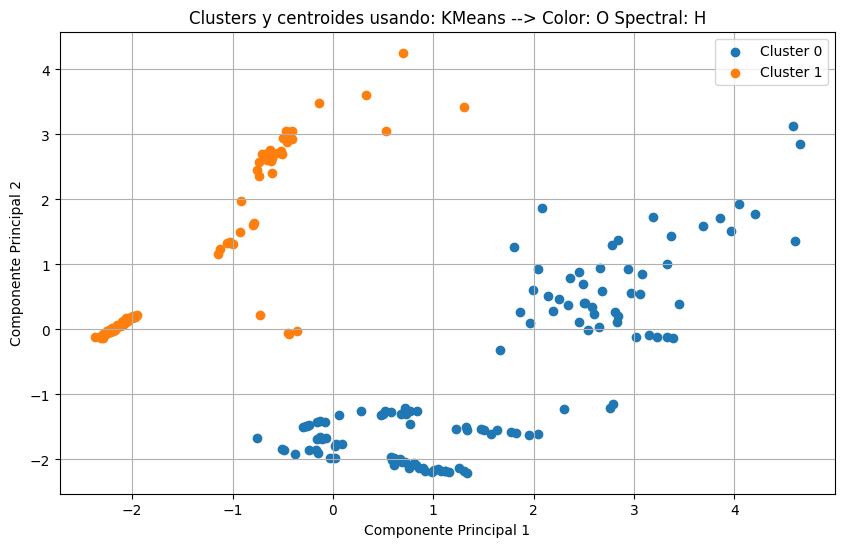

  Clustering Algorithm: Hierarchical Clustering


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

Para Hierarchical Clustering ---- Teniendo: Color O ----- Spectral ----- H
La mejor puntuación usando {} = nan
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}
    Cluster 0: 122 puntos
    Cluster 1: 118 puntos


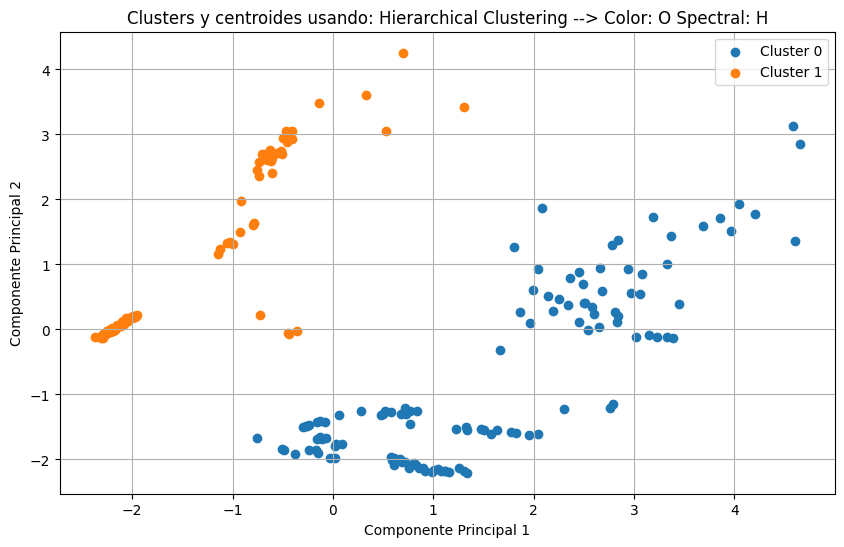

  Clustering Algorithm: DBSCAN


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

Para DBSCAN ---- Teniendo: Color O ----- Spectral ----- H
La mejor puntuación usando {} = nan
 Los mejores parámetos = {'eps': 0.1, 'metric': 'euclidean', 'min_samples': 2}
    Cluster -1: 53 puntos
    Cluster 0: 80 puntos
    Cluster 1: 3 puntos
    Cluster 2: 4 puntos
    Cluster 3: 21 puntos
    Cluster 4: 3 puntos
    Cluster 5: 3 puntos
    Cluster 6: 2 puntos
    Cluster 7: 4 puntos
    Cluster 8: 2 puntos
    Cluster 9: 7 puntos
    Cluster 10: 4 puntos
    Cluster 11: 2 puntos
    Cluster 12: 2 puntos
    Cluster 13: 2 puntos
    Cluster 14: 3 puntos
    Cluster 15: 10 puntos
    Cluster 16: 3 puntos
    Cluster 17: 2 puntos
    Cluster 18: 3 puntos
    Cluster 19: 4 puntos
    Cluster 20: 5 puntos
    Cluster 21: 3 puntos
    Cluster 22: 2 puntos
    Cluster 23: 2 puntos
    Cluster 24: 2 puntos
    Cluster 25: 2 puntos
    Cluster 26: 4 puntos
    Cluster 27: 3 puntos


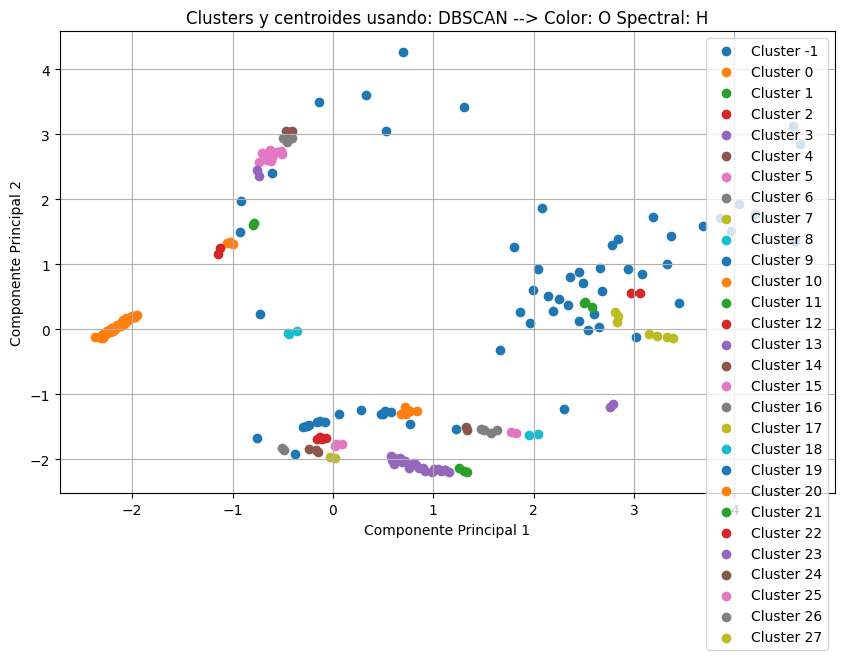



Data Combination: Color Encoding - H, Spectral Encoding - O
Distribución de puntos por cluster
  Clustering Algorithm: KMeans


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

Para KMeans ---- Teniendo: Color H ----- Spectral ----- O
La mejor puntuación usando {} = nan
 Los mejores parámetos = {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 2, 'tol': 0.0001}
    Cluster 0: 118 puntos
    Cluster 1: 122 puntos


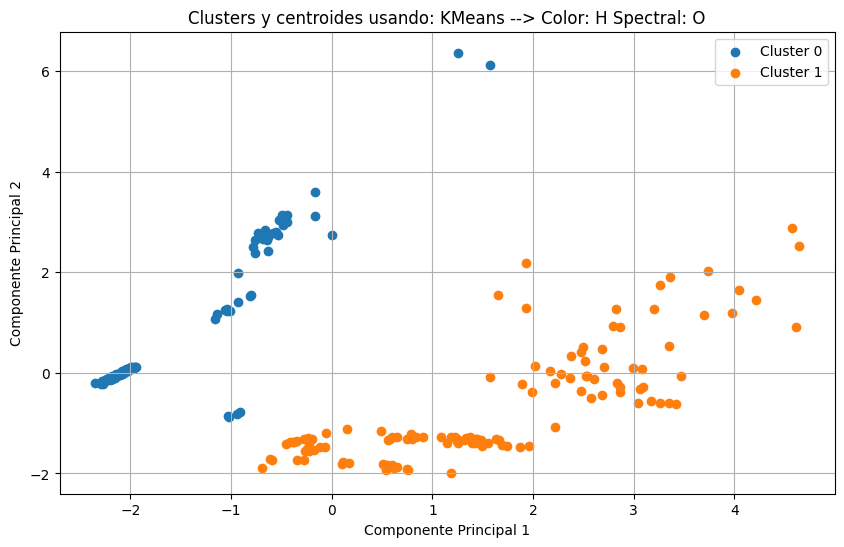

  Clustering Algorithm: Hierarchical Clustering


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

Para Hierarchical Clustering ---- Teniendo: Color H ----- Spectral ----- O
La mejor puntuación usando {} = nan
 Los mejores parámetos = {'compute_distances': True, 'compute_full_tree': True, 'distance_threshold': None, 'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 2}
    Cluster 0: 126 puntos
    Cluster 1: 114 puntos


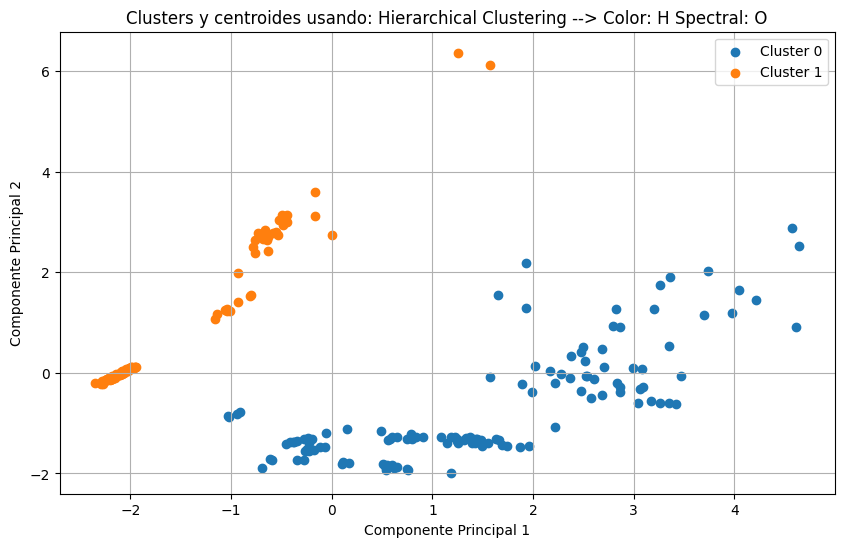

  Clustering Algorithm: DBSCAN


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

Para DBSCAN ---- Teniendo: Color H ----- Spectral ----- O
La mejor puntuación usando {} = nan
 Los mejores parámetos = {'eps': 0.1, 'metric': 'euclidean', 'min_samples': 2}
    Cluster -1: 52 puntos
    Cluster 0: 80 puntos
    Cluster 1: 6 puntos
    Cluster 2: 9 puntos
    Cluster 3: 10 puntos
    Cluster 4: 2 puntos
    Cluster 5: 3 puntos
    Cluster 6: 2 puntos
    Cluster 7: 4 puntos
    Cluster 8: 2 puntos
    Cluster 9: 4 puntos
    Cluster 10: 2 puntos
    Cluster 11: 2 puntos
    Cluster 12: 2 puntos
    Cluster 13: 3 puntos
    Cluster 14: 10 puntos
    Cluster 15: 3 puntos
    Cluster 16: 17 puntos
    Cluster 17: 4 puntos
    Cluster 18: 4 puntos
    Cluster 19: 5 puntos
    Cluster 20: 3 puntos
    Cluster 21: 2 puntos
    Cluster 22: 4 puntos
    Cluster 23: 3 puntos
    Cluster 24: 2 puntos


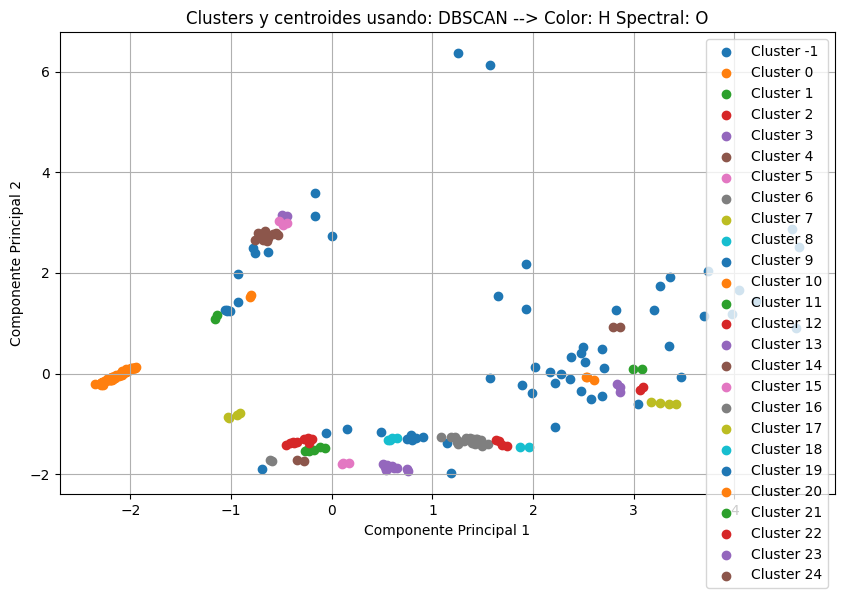



Data Combination: Color Encoding - H, Spectral Encoding - H
Distribución de puntos por cluster
  Clustering Algorithm: KMeans


C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\Administrador\OneDrive\Escritorio\Uni\Tercero Uni\Aprendizaje Automatico\ML-82-17-2\venv\lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Administrador\OneDrive\Esc

KeyboardInterrupt: 

In [83]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

param_grid_kmeans = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8] ,
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2]
}

param_grid_hierarchical = {
    'compute_distances': [True, False],
    'compute_full_tree': [True, False],
    'distance_threshold': [None, 1.0, 2.0],  
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean', 'manhattan', 'cosine'],  
    'n_clusters': [2, 3, 4, 5, 6, 7, 8] 
}


param_grid_dbscan = {
    'eps': [0.1, 0.5, 1.0],
    'min_samples': [2, 5, 10],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

# Definir la métrica de evaluación
scoring = 'adjusted_rand_score'

# Definir una lista de algoritmos de clustering
clustering_algorithms = {
    "KMeans": (KMeans(), param_grid_kmeans),
    "Hierarchical Clustering": (AgglomerativeClustering(), param_grid_hierarchical),
    "DBSCAN": (DBSCAN(), param_grid_dbscan)
}

scores = {}

# Aplicar StandardScaler y PCA a todas las combinaciones de datos
for color_encoding, spectral_encoding, df in master_data:
    print(f"Data Combination: Color Encoding - {color_encoding}, Spectral Encoding - {spectral_encoding}")
    
    # Aplicar StandardScaler
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    # Aplicar PCA con 2 componentes
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)
    
    # Iterar sobre los algoritmos de clustering
    print("Distribución de puntos por cluster")
    for algorithm_name, algorithm in clustering_algorithms.items():
        print(f"  Clustering Algorithm: {algorithm_name}")
        
        grid_search = GridSearchCV(algorithm[0], algorithm[1], scoring=scoring)
        # Realizar clustering con el algoritmo actual
        grid_search.fit(df_pca)
        
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        print(f"Para {algorithm_name} ---- Teniendo: Color {color_encoding} ----- Spectral ----- {spectral_encoding}")
        print(f"La mejor puntuación usando {scores} = {best_score}\n Los mejores parámetos = {best_params}")
        # Mostrar los resultados de los clusters
        best_estimator = grid_search.best_estimator_
        cluster_labels = best_estimator.labels_
        unique_labels = np.unique(cluster_labels)
        for label in unique_labels:
            print(f"    Cluster {label}: {np.sum(cluster_labels == label)} puntos")
        
        # Plot de los datos y los clusters
        plt.figure(figsize=(10, 6))
        for label in unique_labels:
            plt.scatter(df_pca[cluster_labels == label, 0], df_pca[cluster_labels == label, 1], label=f'Cluster {label}')

        plt.xlabel('Componente Principal 1')
        plt.ylabel('Componente Principal 2')
        plt.title(f'Clusters y centroides usando: {algorithm_name} --> Color: {color_encoding} Spectral: {spectral_encoding}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    print("\n")


# Conclusiones Finales

# DATOS EN BRUTO


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Carga de datos
data = pd.read_csv('Stars2.csv')
# Mapeo de los valores de los colores
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())

data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))

# Codificación ordinal de los colores
color_encoder = OrdinalEncoder(categories=[normalized_colors])
data['Color_Encoded'] = color_encoder.fit_transform(data[['Color']])

# Codificación ordinal de la clase espectral
spectral_encoder = OrdinalEncoder(categories=[['O', 'B', 'A', 'F', 'G', 'K', 'M']])
data['Spectral_Class_Encoded'] = spectral_encoder.fit_transform(data[['Spectral_Class']])

# Eliminamos las columnas originales de color y clase espectral
data.drop(['Color', 'Spectral_Class'], axis=1, inplace=True)

# Escalado de características
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Clustering con KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_pca)

# Predicciones de cluster
cluster_labels = kmeans.predict(data_pca)

# Mostrando los resultados
plt.figure(figsize=(10, 6))
for label in np.unique(cluster_labels):
    plt.scatter(data_pca[cluster_labels == label, 0], data_pca[cluster_labels == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters después de PCA')
plt.legend()
plt.grid(True)
#plt.show()

# Y ploteamos nuestro gráfico

kmeans = Kmeans(n_clusters=5)
kmeans.fit(data_pca)

# Mostrando los resultados
plt.figure(figsize=(10, 6))
for label in np.unique(kmeans.labels_):
    plt.scatter(data_pca[kmeans.labels_ == label, 0], data_pca[kmeans.labels_ == label, 1], label=f'Cluster {label}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='X', color='black', label='Centroides')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clusters con KMeans personalizado')
plt.legend()
plt.grid(True)
#plt.show()




# Implementación en bruto de las combinaciones de OHE y Ordinal

In [ ]:
# Test another algorithm, the hierarchical clustering and DBSCAN

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# Clustering jerárquico
data = load_data()
mapping = {
    "Red": ["Red"],
    "Orange-Red": ["Orange-Red"],
    "Orange": ["Orange"],
    "Yellow-Orange": ["Pale yellow orange"],
    "Yellow": ["yellowish", "Yellowish"],
    "White-Yellow": ["Yellowish White", "yellow-white", "White-yellow"],
    "White": ["White", "Whitish", "white"],
    "Blue-white": ["Blue-White", "Blue-white", "Blue White", "Blue white"],
    "Blue": ["Blue"]
}
normalized_colors = list(mapping.keys())
spectrum = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

data['Color'] = data['Color'].apply(lambda x: next((k for k, v in mapping.items() if x in v), x))

# Primero siempre color y luego clase espectral
master_data = {("H", "O"): data.copy(),
                ("H", "H"): data.copy(),
                ("O", "O"): data.copy(),
                ("O", "H"): data.copy()}

######## Sección OO ########
color_encoder = OrdinalEncoder(categories=[normalized_colors])
master_data[("O", "O")]['Color_Encoded'] = color_encoder.fit_transform(master_data[("O", "O")][['Color']])

# Codificación ordinal de la clase espectral
spectral_encoder = OrdinalEncoder(categories=[spectrum])
master_data[("O", "O")]['Spectral_Class_Encoded'] = spectral_encoder.fit_transform(master_data[("O", "O")][['Spectral_Class']])

# Eliminamos las columnas originales de color y clase espectral
master_data[("O", "O")].drop(['Color', 'Spectral_Class'], axis=1, inplace=True)


######## Sección HH ########
color_encoder = OneHotEncoder(categories=[normalized_colors])
color_encoded = color_encoder.fit_transform(master_data[("H", "H")][['Color']])
color_encoded_df = pd.DataFrame(color_encoded.toarray(), columns=[f'Color_{i}' for i in range(1, 10)])
master_data[("H", "H")] = pd.concat([master_data[("H", "H")], color_encoded_df], axis=1)


# Codificación ordinal de la clase espectral
spectral_encoder = OneHotEncoder(categories=[spectrum])
spectral_encoded = spectral_encoder.fit_transform(master_data[("H", "H")][['Spectral_Class']])
spectral_encoded_df = pd.DataFrame(spectral_encoded.toarray(), columns=[f'Spectral_Class_{i}' for i in range(1, 8)])
master_data[("H", "H")] = pd.concat([master_data[("H", "H")], spectral_encoded_df], axis=1)

# Eliminamos las columnas originales de color y clase espectral
master_data[("H", "H")].drop(['Color', 'Spectral_Class'], axis=1, inplace=True)


######## Sección HO ########
color_encoder = OneHotEncoder(categories=[normalized_colors])
color_encoded = color_encoder.fit_transform(master_data[("H", "O")][['Color']])
color_encoded_df = pd.DataFrame(color_encoded.toarray(), columns=[f'Color_{i}' for i in range(1, 10)])
master_data[("H", "O")] = pd.concat([master_data[("H", "O")], color_encoded_df], axis=1)

# Codificación ordinal de la clase espectral
spectral_encoder = OrdinalEncoder(categories=[spectrum])
master_data[("H", "O")]['Spectral_Class_Encoded'] = spectral_encoder.fit_transform(master_data[("H", "O")][['Spectral_Class']])

# Eliminamos las columnas originales de color y clase espectral
master_data[("H", "O")].drop(['Color', 'Spectral_Class'], axis=1, inplace=True)


######## Sección OH ########
color_encoder = OrdinalEncoder(categories=[normalized_colors])
master_data[("O", "H")]['Color_Encoded'] = color_encoder.fit_transform(master_data[("O", "H")][['Color']])

# Codificación ordinal de la clase espectral
spectral_encoder = OneHotEncoder(categories=[spectrum])
spectral_encoded = spectral_encoder.fit_transform(master_data[("O", "H")][['Spectral_Class']])
spectral_encoded_df = pd.DataFrame(spectral_encoded.toarray(), columns=[f'Spectral_Class_{i}' for i in range(1, 8)])
master_data[("O", "H")] = pd.concat([master_data[("O", "H")], spectral_encoded_df], axis=1)

# Eliminamos las columnas originales de color y clase espectral
master_data[("O", "H")].drop(['Color', 'Spectral_Class'], axis=1, inplace=True)

